In [1]:
import os
import cv2 #open cv
import numpy as np
import matplotlib.pyplot as plt


## Load data

In [2]:
def load_dataset(dataset_path):
    data = []
    labels = []
    label_id = 0
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            for img_path in os.listdir(folder_path):
                # test if img_path is a valid file
                if not img_path.endswith(".jpeg"):
                    print("Skipping file: ", img_path)
                    continue
                img = cv2.imread(os.path.join(folder_path, img_path), cv2.IMREAD_GRAYSCALE)
                #print(img, os.path.join(folder_path, img_path))
                if img is None:
                    print("Error: Could not read the image")
                else:
                    img_resized = cv2.resize(img, (32, 32))
                    img_flattened = img_resized.flatten()

                    data.append(img_flattened)
                    labels.append(label_id)
            label_id +=1

    return np.array(data), np.array(labels)

dataset_test_path = "../data/chest_Xray/test"
dataset_train_path = "../data/chest_Xray/train"
dataset_val_path = "../data/chest_Xray/val"

In [3]:
# load data
# pas besoin du train test split puisque les donées sont déjà filter dans les sous dossiers
X_train, y_train = load_dataset(dataset_train_path)
X_test, y_test = load_dataset(dataset_test_path)
X_val, y_val = load_dataset(dataset_val_path)

Skipping file:  .DS_Store
Skipping file:  .DS_Store
Skipping file:  .DS_Store
Skipping file:  .DS_Store


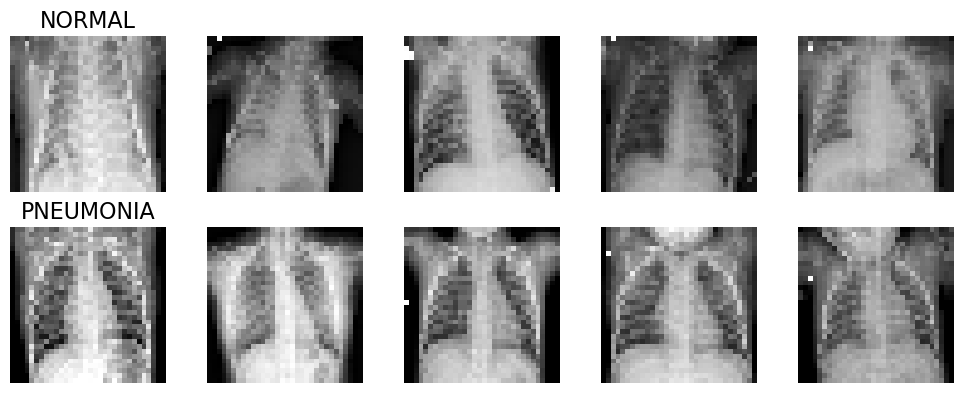

In [4]:
def visualize_data(data, labels, label_names, num_images_per_class=10):
    num_classes = len(set(labels))
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    
    for label_id in range(num_classes):
        label_indices = np.where(labels == label_id)[0]
        sample_indices = np.random.choice(label_indices, size=num_images_per_class, replace=False)

        for i, img_index in enumerate(sample_indices):
            img = data[img_index].reshape(32, 32)
            axes[label_id, i].imshow(img, cmap='gray')
            axes[label_id, i].axis('off')

            if i == 0:
                axes[label_id, i].set_title(label_names[label_id], fontsize=16)

    plt.tight_layout()
    plt.show()

label_names = ["NORMAL", "PNEUMONIA"]
visualize_data(X_train, y_train, label_names, num_images_per_class=5)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [6]:

def createLinearSVC(max_iter):
    svc = LinearSVC(random_state=0, max_iter=max_iter)
    svc.fit(X_train, y_train)
    return svc



In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

svc = createLinearSVC(max_iter=4000)

#val
y_pred = svc.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy VAL: {accuracy * 100:.2f}%")



Validation Accuracy VAL: 81.25%


/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

print(X.shape, y.shape)


(5232, 1024) (5232,)


In [9]:
from sklearn.model_selection import cross_val_score

lsvc = createLinearSVC(max_iter=20000)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
cv_scores = cross_val_score(
    lsvc,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 93.75% (+/- 0.70%


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Générer le rapport de classification
report = classification_report(y_test, y_pred)

# Afficher le rapport de classification
print(report)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Confusion Matrix:\n{cm}")

              precision    recall  f1-score   support

           0       0.90      0.29      0.44       390
           1       0.44      0.94      0.60       234

    accuracy                           0.54       624
   macro avg       0.67      0.62      0.52       624
weighted avg       0.73      0.54      0.50       624

Accuracy: 0.54
Precision: 0.73
Recall: 0.54
F1-score: 0.50
Confusion Matrix:
[[113 277]
 [ 13 221]]


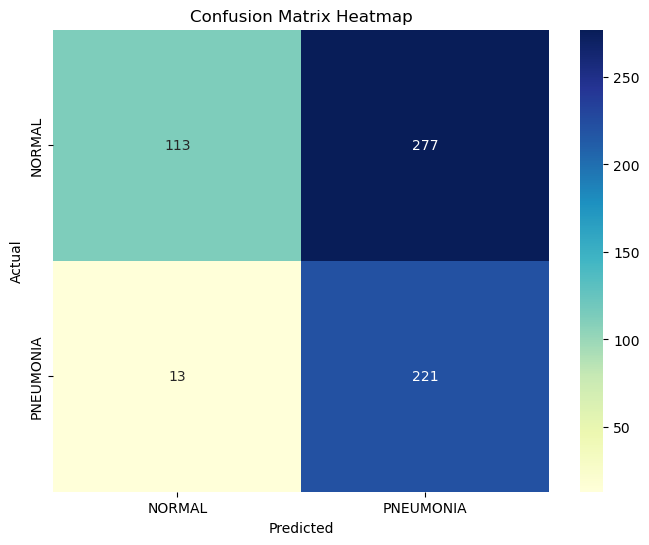

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.29      0.44       390
   PNEUMONIA       0.44      0.94      0.60       234

    accuracy                           0.54       624
   macro avg       0.67      0.62      0.52       624
weighted avg       0.73      0.54      0.50       624



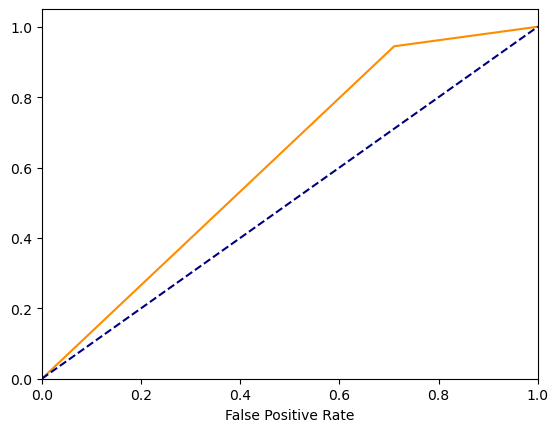

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

# Classification Report
report = classification_report(y_test, y_pred, target_names=label_names)
print(f"Classification Report:\n{report}")

# ROC Curve and AUC (for binary classification)
if len(label_names) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')

In [12]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=20, weights="uniform")
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 62.50%


In [13]:
cv_scores = cross_val_score(
    neigh,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 91.82% (+/- 0.54%


In [14]:
from sklearn.svm import SVC

svc = SVC(kernel="linear", C=1, random_state=0)
cv_scores = cross_val_score(
    svc,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 94.63% (+/- 0.47%


In [15]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(random_state=0, eval_metric='mlogloss')
cv_scores = cross_val_score(
    xgb_classifier,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 95.97% (+/- 0.51%


In [16]:
from sklearn.tree import DecisionTreeClassifier 

tree = DecisionTreeClassifier(random_state=0)
cv_scores = cross_val_score(
    tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 87.31% (+/- 0.78%


In [17]:
from sklearn.ensemble import RandomForestClassifier 


tree = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
cv_scores = cross_val_score(tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 92.74% (+/- 1.16%


In [18]:
from sklearn.ensemble import ExtraTreesClassifier 


tree = ExtraTreesClassifier(n_estimators=1000, max_depth=None,
    min_samples_split=2, random_state=0)
cv_scores = cross_val_score(tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)
cv_scores.mean()

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 94.97% (+/- 0.81%


In [19]:
from sklearn.ensemble import AdaBoostClassifier 


tree = AdaBoostClassifier(n_estimators=100)
cv_scores = cross_val_score(tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)
cv_scores.mean()

mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 94.92% (+/- 0.63%


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

tree = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0,
    max_depth=1, random_state=0)
cv_scores = cross_val_score(tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 94.00% (+/- 1.37%


In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier

tree = HistGradientBoostingClassifier(max_iter=100)
cv_scores = cross_val_score(tree,
    X,
    y,
    cv=5,
    scoring='accuracy'
)
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {mean_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%")

Cross-Validation Accuracy: 95.89% (+/- 0.47%
